In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import qutip as qt
#from scipy import ndimage, misc
#from ifigures import *
#from ifigures.my_plots import *
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.linalg import kron, eig
import time

In [2]:
import matplotlib.colors as mcolors
import colorsys


#: Durham colour scheme
cDUp = "#7E317B"  # Palatinate Purple
cDUpp =  "#D8ACF4"  # Light purple

cDUb = "#006388"  # Blue
cDUbb = "#91B8BD"  # Mid Blue
cDUbbb = "#C4E5FA"  # Light Blue
cDUbbbb = "#00AEEF"

cDUsky = "#A5C8D0"  # sky blue

cDUo = "#9FA161"  # Olive Green

cDUr = "#AA2B4A"  # Red
cDUrr = "#BE1E2D"
cDUy = "#E8E391" #  Yellow

cDUp = "#C43B8E" # Pink

cDUk = "#231F20"  # Black
cDUkk = "#002A41" # ink

cDUggg = "#CFDAD1"  # Near White/L. Grey
cDUgg = "#968E85"  # Warm Grey
cDUg = "#6E6464"  # midgrey

In [3]:
def make_colormap(seq):
    """
        Args:
            seq: a sequence of floats and RGB-tuples. The floats should be
                increasing and in the interval (0,1).

        Returns:
            a LinearSegmentedColormap
    """
    seq = [(None, ) * 3, 0.0] + list(seq) + [1.0, (None, ) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
rvb = make_colormap([
    c('#b20000'),
    c('#fe7600'), 0.125,
    c('#fe7600'),
    c('#feca00'), 0.25,
    c('#feca00'),
    c('#bcfd00'), 0.375,
    c('#bcfd00'),
    c('#06a133'), 0.5,
    c('#06a133'),
    c('#00f6fd'), 0.625,
    c('#00f6fd'),
    c('#000cfe'), 0.75,
    c('#000cfe'),
    c('#e404fe'), 0.875,
    c('#e404fe'),
    c('#b20000')
])


def getColor(amplitude, phase, maxAmplitude):
    c = rvb(phase / (2. * np.pi))
    scale = amplitude / maxAmplitude
    if scale > 1:
        raise ValueError(
            'Amplitude of the passed complex number is bigger than the'
            ' maximal set amplitudeyter not')
    cc = colorsys.rgb_to_hls(c[0], c[1], c[2])
    c = colorsys.hls_to_rgb(cc[0], cc[1] + (1. - scale) * (1. - cc[1]), cc[2])
    return (c[0], c[1], c[2], 1.0)


def getComplexColor(complexNo, maxAmplitude):
    """
    Get color for a complex numbers

    Represents phase as continous colour wheel, and amplitude as intensity
    of color (zero amplitude = white color), with linear mapping in between.

    Args:
        complexNo (complex float): complex number
        maxAmplitude (float): maximum amplitude in the data set we want to
            represent as colour mapped dots. This is used for normalizing color
            intensity, going from maximal saturation or `maxAmplitude` to
            white color for zero amplitude.

    Returns:
        color as [red, green, blue, alpha]
    """
    angle = np.angle(complexNo)
    if angle < 0:
        angle += 2 * np.pi
    return getColor(np.absolute(complexNo), angle, maxAmplitude)

def white_to_transparency(img):
    """
        Converts white areas of image to transprancy.
    """
    x = np.asarray(img.convert('RGBA')).copy()

    x[:, :, 3] = (255 * (x[:, :, :3] != 255).any(axis=2)).astype(np.uint8)

    return Image.fromarray(x)


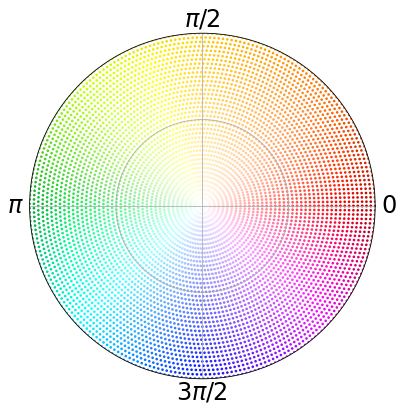

In [4]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

vr=[]
vt=[]
vc=[]

for r in np.linspace(0.02,1,40):
    theta = np.linspace(0,2*np.pi,50+int(r*200))
    x=[]
    y=[]
    for t in theta:
        x.append(r*np.cos(t))
        y.append(r*np.sin(t))

        vt.append(t)
        vr.append(r)
        number = r * (np.cos(t) + 1j * np.sin(t))
        vc.append(getComplexColor(number,1.))
        
ax.scatter(vt, vr, color=vc,lw=0,s=7)
ax.set_rmax(1)
thetaticks = np.arange(0,360,90)

# set ticklabels location at1.3 times the axes' radius
ax.set_thetagrids(thetaticks)
ax.set_xticklabels(["0",r"$\pi/2$",r"$\pi$",r"$3\pi/2$"],fontsize=24)
#ax.set_thetagrids([])

#ax.set_xticklabels([])
ax.set_yticks([0.5,1])
#ax.set_yticks([])
ax.set_yticklabels([])
#plt.savefig('phase_amplitude_map2.png', transparent=True,bbox_inches='tight',dpi=800)
plt.show()

In [5]:
def OBE(Gamma,Omega,Delta,tmax,npts):
    phiL=1.0*np.pi/2
    H=np.array([[Delta/2, (Omega/2)*np.exp(-1.j*phiL)],[(Omega/2)*np.exp(1.j*phiL), -Delta/2] ])
    I2=np.eye(2,2)
    Hrho=kron(H,I2)
    rhoH=kron(I2,np.conj(H))

    L=np.zeros((4,4))
    L[0,3]=Gamma
    L[1,1]=-Gamma/2
    L[2,2]=-Gamma/2
    L[3,3]=-Gamma

    evals, evecs = eig(-1.j*(Hrho-rhoH)+L)
    evecs=np.mat(evecs)

    rho0=np.zeros((4,1))
    rho0[0]=1.0
    rho0[0]=0.5
    rho0[1]=0.5
    rho0[2]=0.5
    rho0[3]=0.5
    t=np.linspace(0,tmax,npts)
    rho_aa=(1.0+1.0j)*np.zeros(npts)
    rho_ab=(1.0+1.0j)*np.zeros(npts)
    rho_ba=(1.0+1.0j)*np.zeros(npts)
    rho_bb=(1.0+1.0j)*np.zeros(npts)

    for i in range(0,npts):
        rho=evecs*np.mat(np.diag(np.exp(evals*t[i])))*np.linalg.inv(evecs)*rho0
        rho_aa[i]=rho[0]
        rho_ab[i]=rho[1]
        rho_ba[i]=rho[2]
        rho_bb[i]=rho[3]
        
    return rho_aa, rho_ab, rho_ba, rho_bb

In [6]:
start = time.time()
npts=800
tmax=2.0*np.pi*1
Gamma=1.0 #input parameter
Delta=10.0
Omega=0.0

t=np.linspace(0,tmax,npts)

rho_aa, rho_ab, rho_ba, rho_bb = OBE(Gamma,Omega,Delta,tmax,npts)


end = time.time()
print(end - start)

0.06037616729736328


<ipython-input-7-b5946039e78a>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax.append( fig.add_subplot(rows, columns, i) )


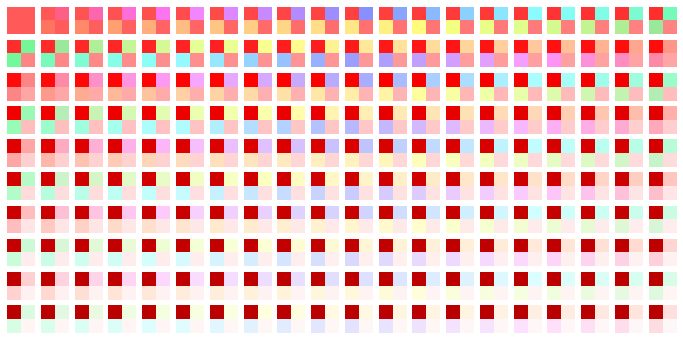

In [7]:
dim=2

R=np.zeros((dim,dim))
G=np.zeros((dim,dim))
B=np.zeros((dim,dim))

fig=plt.figure(figsize=(12, 6))
ax = []
columns = 20
rows = 10
for i in range(1, columns*rows +1):
    t_index=2*(i-1)
    R[0,0]=getComplexColor(rho_aa[t_index],1.)[0]
    G[0,0]=getComplexColor(rho_aa[t_index],1.)[1]
    B[0,0]=getComplexColor(rho_aa[t_index],1.)[2]

    R[0,1]=getComplexColor(rho_ab[t_index],1.)[0]
    G[0,1]=getComplexColor(rho_ab[t_index],1.)[1]
    B[0,1]=getComplexColor(rho_ab[t_index],1.)[2]

    R[1,0]=getComplexColor(rho_ba[t_index],1.)[0]
    G[1,0]=getComplexColor(rho_ba[t_index],1.)[1]
    B[1,0]=getComplexColor(rho_ba[t_index],1.)[2]

    R[1,1]=getComplexColor(rho_bb[t_index],1.)[0]
    G[1,1]=getComplexColor(rho_bb[t_index],1.)[1]
    B[1,1]=getComplexColor(rho_bb[t_index],1.)[2]
    RGB=np.dstack((R, G, B))
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(RGB)
    ax.append( fig.add_subplot(rows, columns, i) )
    ax[i-1].set_axis_off()

plt.show()

# 2. Bell state

$$\textstyle{1 \over \sqrt{2}}(\vert 00\rangle+\vert 11\rangle)$$

Rabi driving of both qubits.

In [8]:
def OBE(Gamma,Omega,Delta,tmax,npts):
    phiL=1.0*np.pi/2
    H1=np.array([[Delta/2, (Omega/2)*np.exp(-1.j*phiL)],[(Omega/2)*np.exp(1.j*phiL), -Delta/2] ])
    
    I2=np.eye(2,2)
    H=kron(H1,I2)+kron(I2,H1) # Hamiltonian H1 acting independent on qubit 1 and 2
    I4=np.eye(4,4)
    Hrho=kron(H,I4)
    rhoH=kron(I4,np.conj(H))

    L1=np.zeros((4,4))
    L1[0,3]=Gamma
    L1[1,1]=-Gamma/2
    L1[2,2]=-Gamma/2
    L1[3,3]=-Gamma
    
    L=kron(L1,I4)+kron(I4,L1) # combined decay matrix


    evals, evecs = eig(-1.j*(Hrho-rhoH)+L)
    evecs = np.mat(evecs)

    rho_init = np.zeros((16,1)) # initial state
    rho_init[0] = 0.5
    rho_init[3] = 0.5
    rho_init[12] = 0.5
    rho_init[15] = 0.5 # Bell state
    t = np.linspace(0,tmax,npts)
    rho0 = (1.0+1.0j)*np.zeros(npts)
    rho1 = (1.0+1.0j)*np.zeros(npts)
    rho2 = (1.0+1.0j)*np.zeros(npts)
    rho3 = (1.0+1.0j)*np.zeros(npts)
    rho4 = (1.0+1.0j)*np.zeros(npts)
    rho5 = (1.0+1.0j)*np.zeros(npts)
    rho6 = (1.0+1.0j)*np.zeros(npts)
    rho7 = (1.0+1.0j)*np.zeros(npts)
    rho8 = (1.0+1.0j)*np.zeros(npts)
    rho9 = (1.0+1.0j)*np.zeros(npts)
    rho10 = (1.0+1.0j)*np.zeros(npts)
    rho11 = (1.0+1.0j)*np.zeros(npts)
    rho12 = (1.0+1.0j)*np.zeros(npts)
    rho13 = (1.0+1.0j)*np.zeros(npts)
    rho14 = (1.0+1.0j)*np.zeros(npts)
    rho15 = (1.0+1.0j)*np.zeros(npts)

    for i in range(0,npts):
        rho=evecs*np.mat(np.diag(np.exp(evals*t[i])))*np.linalg.inv(evecs)*rho_init
        rho0[i]=rho[0]
        rho1[i]=rho[1]
        rho2[i]=rho[2]
        rho3[i]=rho[3]
        rho4[i]=rho[4]
        rho5[i]=rho[5]
        rho6[i]=rho[6]
        rho7[i]=rho[7]
        rho8[i]=rho[8]
        rho9[i]=rho[9]
        rho10[i]=rho[10]
        rho11[i]=rho[11]
        rho12[i]=rho[12]
        rho13[i]=rho[13]
        rho14[i]=rho[14]
        rho15[i]=rho[15]
        
    return rho0, rho1, rho2, rho3, rho4, rho5, rho6, rho7, rho8, rho9, rho10, rho11, rho12, rho13, rho14, rho15

In [9]:
start = time.time()
npts=800
tmax=2.0*np.pi*1
Gamma=0.0 #input parameter
Delta=10.0
Omega=1.0

t=np.linspace(0,tmax,npts)

rho0, rho1, rho2, rho3, rho4, rho5, rho6, rho7, rho8, rho9, rho10, rho11, rho12, rho13, rho14, rho15 = OBE(Gamma,Omega,Delta,tmax,npts)


end = time.time()
print(end - start)

0.27788400650024414


<ipython-input-10-b0665a35e5b7>:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax.append( fig.add_subplot(rows, columns, i) )


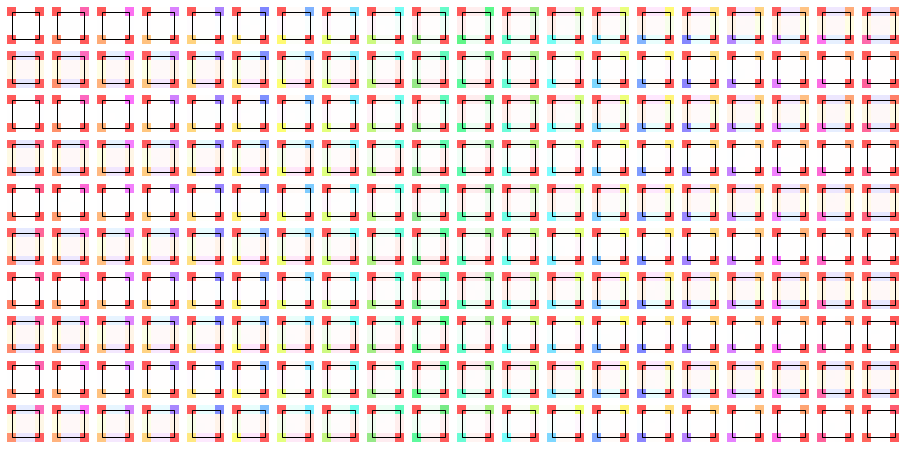

In [10]:
import matplotlib.patches as patches


dim=4

R=np.zeros((dim,dim))
G=np.zeros((dim,dim))
B=np.zeros((dim,dim))

fig=plt.figure(figsize=(16, 8))
ax = []
columns = 20
rows = 10
for i in range(1, columns*rows +1):
    t_index=2*(i-1)

    R[0,0]=getComplexColor(rho0[t_index],1.)[0]
    G[0,0]=getComplexColor(rho0[t_index],1.)[1]
    B[0,0]=getComplexColor(rho0[t_index],1.)[2]

    R[0,1]=getComplexColor(rho1[t_index],1.)[0]
    G[0,1]=getComplexColor(rho1[t_index],1.)[1]
    B[0,1]=getComplexColor(rho1[t_index],1.)[2]

    R[0,2]=getComplexColor(rho2[t_index],1.)[0]
    G[0,2]=getComplexColor(rho2[t_index],1.)[1]
    B[0,2]=getComplexColor(rho2[t_index],1.)[2]

    R[0,3]=getComplexColor(rho3[t_index],1.)[0]
    G[0,3]=getComplexColor(rho3[t_index],1.)[1]
    B[0,3]=getComplexColor(rho3[t_index],1.)[2]


    R[1,0]=getComplexColor(rho4[t_index],1.)[0]
    G[1,0]=getComplexColor(rho4[t_index],1.)[1]
    B[1,0]=getComplexColor(rho4[t_index],1.)[2]
    
    R[1,1]=getComplexColor(rho5[t_index],1.)[0]
    G[1,1]=getComplexColor(rho5[t_index],1.)[1]
    B[1,1]=getComplexColor(rho5[t_index],1.)[2]

    R[1,2]=getComplexColor(rho6[t_index],1.)[0]
    G[1,2]=getComplexColor(rho6[t_index],1.)[1]
    B[1,2]=getComplexColor(rho6[t_index],1.)[2]

    R[1,3]=getComplexColor(rho7[t_index],1.)[0]
    G[1,3]=getComplexColor(rho7[t_index],1.)[1]
    B[1,3]=getComplexColor(rho7[t_index],1.)[2]
    
    
    R[2,0]=getComplexColor(rho8[t_index],1.)[0]
    G[2,0]=getComplexColor(rho8[t_index],1.)[1]
    B[2,0]=getComplexColor(rho8[t_index],1.)[2]

    R[2,1]=getComplexColor(rho9[t_index],1.)[0]
    G[2,1]=getComplexColor(rho9[t_index],1.)[1]
    B[2,1]=getComplexColor(rho9[t_index],1.)[2]

    R[2,2]=getComplexColor(rho10[t_index],1.)[0]
    G[2,2]=getComplexColor(rho10[t_index],1.)[1]
    B[2,2]=getComplexColor(rho10[t_index],1.)[2]

    R[2,3]=getComplexColor(rho11[t_index],1.)[0]
    G[2,3]=getComplexColor(rho11[t_index],1.)[1]
    B[2,3]=getComplexColor(rho11[t_index],1.)[2]
    
    
    R[3,0]=getComplexColor(rho12[t_index],1.)[0]
    G[3,0]=getComplexColor(rho12[t_index],1.)[1]
    B[3,0]=getComplexColor(rho12[t_index],1.)[2]

    R[3,1]=getComplexColor(rho13[t_index],1.)[0]
    G[3,1]=getComplexColor(rho13[t_index],1.)[1]
    B[3,1]=getComplexColor(rho13[t_index],1.)[2]

    R[3,2]=getComplexColor(rho14[t_index],1.)[0]
    G[3,2]=getComplexColor(rho14[t_index],1.)[1]
    B[3,2]=getComplexColor(rho14[t_index],1.)[2]

    R[3,3]=getComplexColor(rho15[t_index],1.)[0]
    G[3,3]=getComplexColor(rho15[t_index],1.)[1]
    B[3,3]=getComplexColor(rho15[t_index],1.)[2]


    RGB=np.dstack((R, G, B))
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(RGB)
    ax.append( fig.add_subplot(rows, columns, i) )
    ax[i-1].set_axis_off()
    frame = patches.Rectangle((0, 0), 3, 3, linewidth=1, edgecolor='black', facecolor='none')
    ax[i-1].add_patch(frame)


plt.show()